# Exercícios de Árvore de Decisão

## Introdução

Nós usaremos a base de dados sobre qualidade de vinhos para esses exercícios. Essa base de dados contém várias propriedades químicas de diversos vinhos como acidez, açúcar, pH e teor alcólico. A variável alvo é uma métrica de qualidade entre 3 e 9 e a cor, tinto ou branco. O nome do arquivo é `Wine_Quality_Data.csv`.

## Exercício 1

* Importe a base e examine os atributos.
* Nós utilizaremos como variável alvo o atributo `color` (white / red), mas precisamos codificar como inteiros.

In [1]:
import pandas as pd
import numpy as np

filepath = 'data/Wine_Quality_Data.csv'
data = pd.read_csv(filepath, sep=',')

In [2]:
# imprima as primeiras linhas
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [9]:
# verifique os tipos dos atributos
data.dtypes

fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
color                    object
dtype: object

In [10]:
# altere a coluna 'color' para substituir 'white' por 0 e 'red' por 1

data['color'] = data.color.replace({'red': 1, 'white': 0})

## Exercício 2

* Use `StratifiedShuffleSplit` para dividir os dados em treino e teste mas estratificados pela variável alvo. 
* Verifique a distribuição das classes no treino e no teste.

In [11]:
# All data columns except for color
feature_cols = [x for x in data.columns if x not in 'color']

from sklearn.model_selection import StratifiedShuffleSplit

# Split the data into two parts with 1000 points in the test data
# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1000, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['color']))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'color']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'color']

In [12]:
# Use o método value_counts com normalização para verificar a distribuição
y_train.value_counts(normalize=1)

0    0.753866
1    0.246134
Name: color, dtype: float64

In [13]:
y_test.value_counts(normalize=1)

0    0.754
1    0.246
Name: color, dtype: float64

## Exercício 3

* Aplique uma árvore de decisão sem limite na profundidade máxima, atributos ou folhas.
* Verifique quantos nós estão presentes na árvore gerada e a profundidade dela.
* Usando essa árvore, verifique o erro de predição nas bases de treino e teste. O que acha que levou a essa diferença nos valores dos erros?

In [17]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

In [19]:
# quantos nós e profundidade
dt.tree_.max_depth, dt.tree_.node_count

(22, 171)

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# função para retornar diversas métricas
def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [22]:
# The error on the training and test data sets
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,0.999818,0.984000
f1,0.999631,0.967611
precision,0.999261,0.963710
recall,1.000000,0.971545


## Exercício 4

* Usando o Grid Search com Validação Cruzada do Scikit-Learn, encontre uma árvore de decisão que tem a melhor performance na base de teste. Use um nome diferente para essa árvore para compararmos ambas no exercício 6.
* Determine o número de nós e profundidade dessa árvore.
* Calcule as métricas para essa árvore.

In [23]:
from sklearn.model_selection import GridSearchCV

# variação de parâmetros que queremos testar
param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',  # vamos maximizar acurácia, teste com outras métricas
                  n_jobs=-1)

# aplicamos apenas na base de treino, obviamente
GR = GR.fit(X_train, y_train)

In [25]:
# número de nós e profundidade
GR.best_estimator_.tree_.max_depth, GR.best_estimator_.tree_.node_count

(7, 99)

In [29]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)

train_test_gr_error

,train,test
accuracy,0.995816,0.989000
f1,0.991440,0.977505
precision,0.998501,0.983539
recall,0.984479,0.971545


## Exercício 6 *(Opcional)*

Para esse exercício, instale o programa GraphViz e a biblioteca PyDotPlus (`conda install -c conda-forge pydotplus`).

Com tudo isso instalado crie uma visualização das árvores de decisão do exercício 3 e 4.

In [30]:
from io import StringIO
from IPython.display import Image, display

from sklearn.tree import export_graphviz

try:
    import pydotplus
    pydotplus_installed = True
    
except:
    print('PyDotPlus must be installed to execute the remainder of the cells associated with this question.')
    print('Please see the instructions for this question for details.')
    pydotplus_installed = False

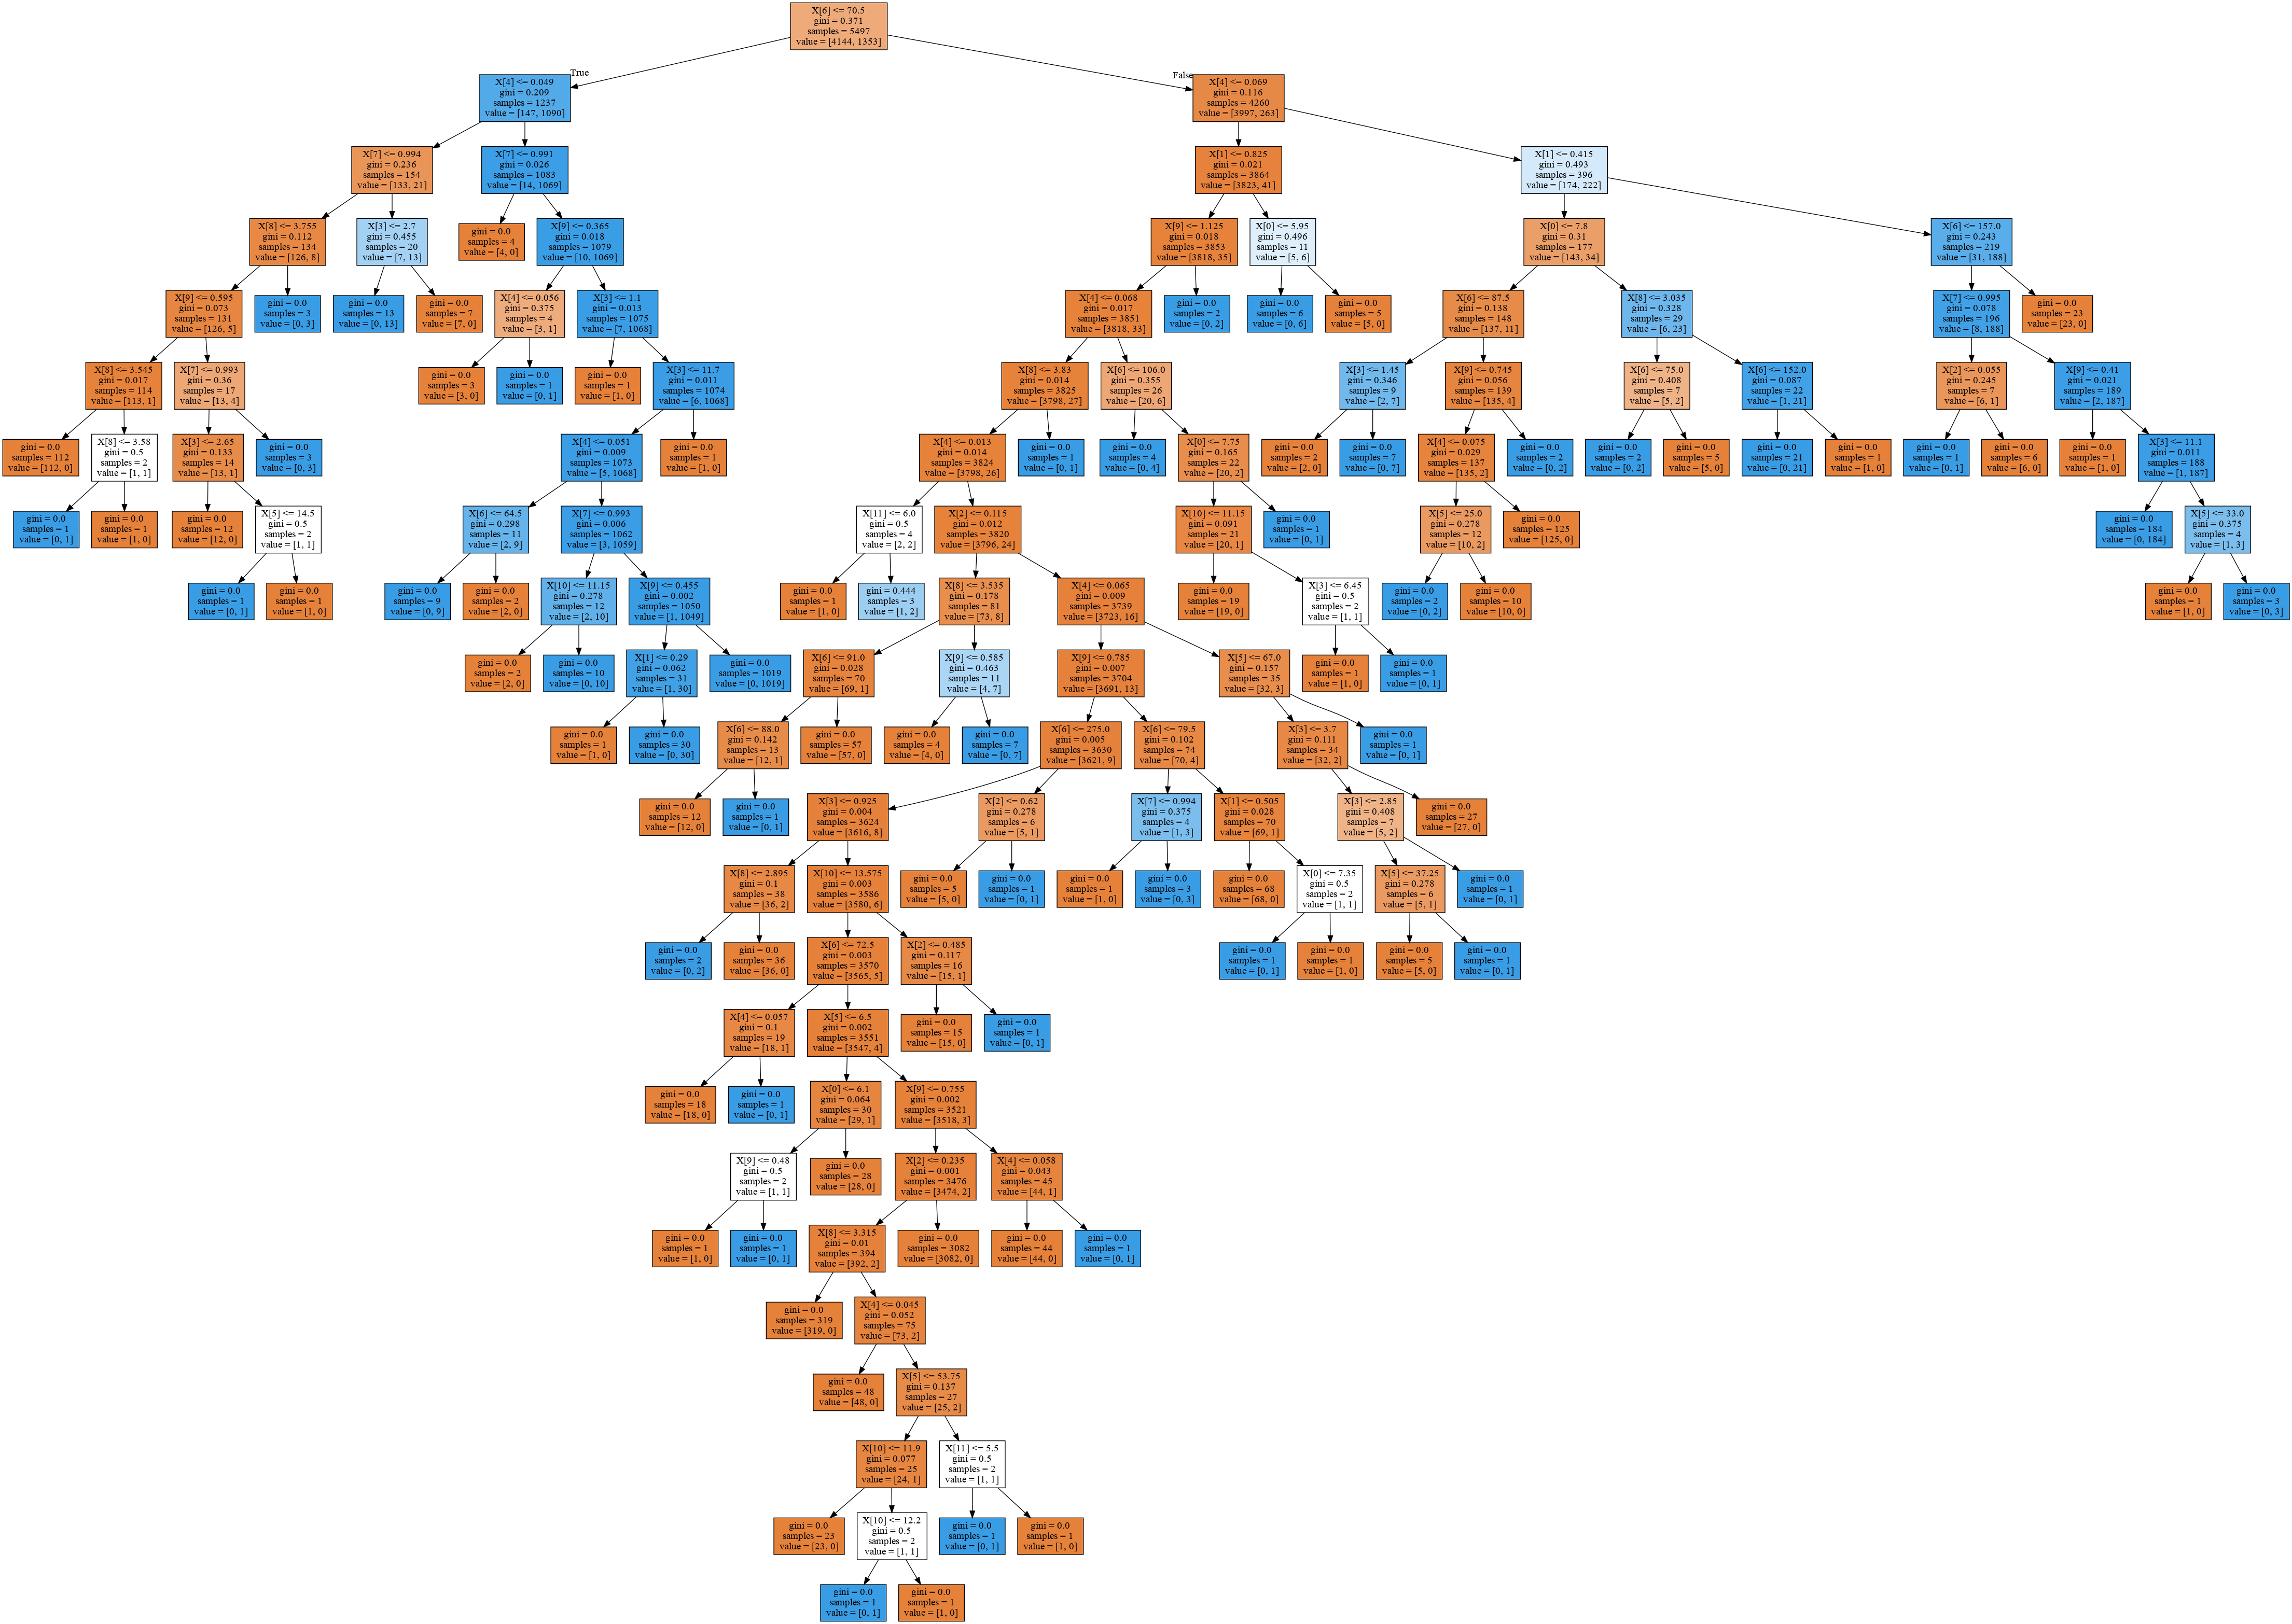

In [31]:
# Árvore do Exercício 3

if pydotplus_installed:
    
    # Create an output destination for the file
    dot_data = StringIO()

    export_graphviz(dt, out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # View the tree image
    filename = 'wine_tree.png'
    graph.write_png(filename)
    img = Image(filename=filename)
    display(img)
    
else:
    print('This cell not executed because PyDotPlus could not be loaded.')

In [ ]:
# Árvore do Exercício 4

if pydotplus_installed:
    
    # Create an output destination for the file
    dot_data = StringIO()

    export_graphviz(GR.best_estimator_, out_file=dot_data, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

    # View the tree image
    filename = 'wine_tree_prune.png'
    graph.write_png(filename)
    img = Image(filename=filename) 
    display(img)
    
else:
    print('This cell not executed because PyDotPlus could not be loaded.')